In [18]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from geopy.distance import great_circle  # For calculating distances
import geopandas as gpd
from shapely import wkt
from shapely.wkt import loads
import seaborn as sns

In [19]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df = pd.read_csv("/content/Los_Angeles_Model.csv")
df.head()

,Area ID,Victim Age,Victim Sex,Premise Code,Severity,Factors,Latitude,Longitude,Day of Week,Month,Year,Hour
0,3,22,M,101,2,Traffic Accident,34.0255,-118.3002,Saturday,August,2019,4
1,3,30,F,101,1,Road Rage,34.0256,-118.3089,Friday,August,2019,23
2,4,38,M,101,1,Road Rage,34.0738,-118.2078,Sunday,August,2019,5
3,1,21,M,101,1,Traffic Accident,34.0492,-118.2391,Wednesday,November,2019,3
4,3,49,M,101,2,Traffic Accident,34.0108,-118.3182,Friday,August,2019,21


In [20]:
df = df.convert_dtypes()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588143 entries, 0 to 588142
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Area ID       588143 non-null  Int64  
 1   Victim Age    588143 non-null  Int64  
 2   Victim Sex    588143 non-null  string 
 3   Premise Code  588143 non-null  Int64  
 4   Severity      588143 non-null  Int64  
 5   Factors       588143 non-null  string 
 6   Latitude      588143 non-null  Float64
 7   Longitude     588143 non-null  Float64
 8   Day of Week   588143 non-null  string 
 9   Month         588143 non-null  string 
 10  Year          588143 non-null  Int64  
 11  Hour          588143 non-null  Int64  
dtypes: Float64(2), Int64(6), string(4)
memory usage: 58.3 MB


In [21]:
df['Severity'].value_counts()

1    365126
2    206064
3     16953
Name: Severity, dtype: Int64

In [22]:
severity_mapping = {
    1:0,
    2:1,
    3:1
}

df['Severity'] = df['Severity'].map(severity_mapping)

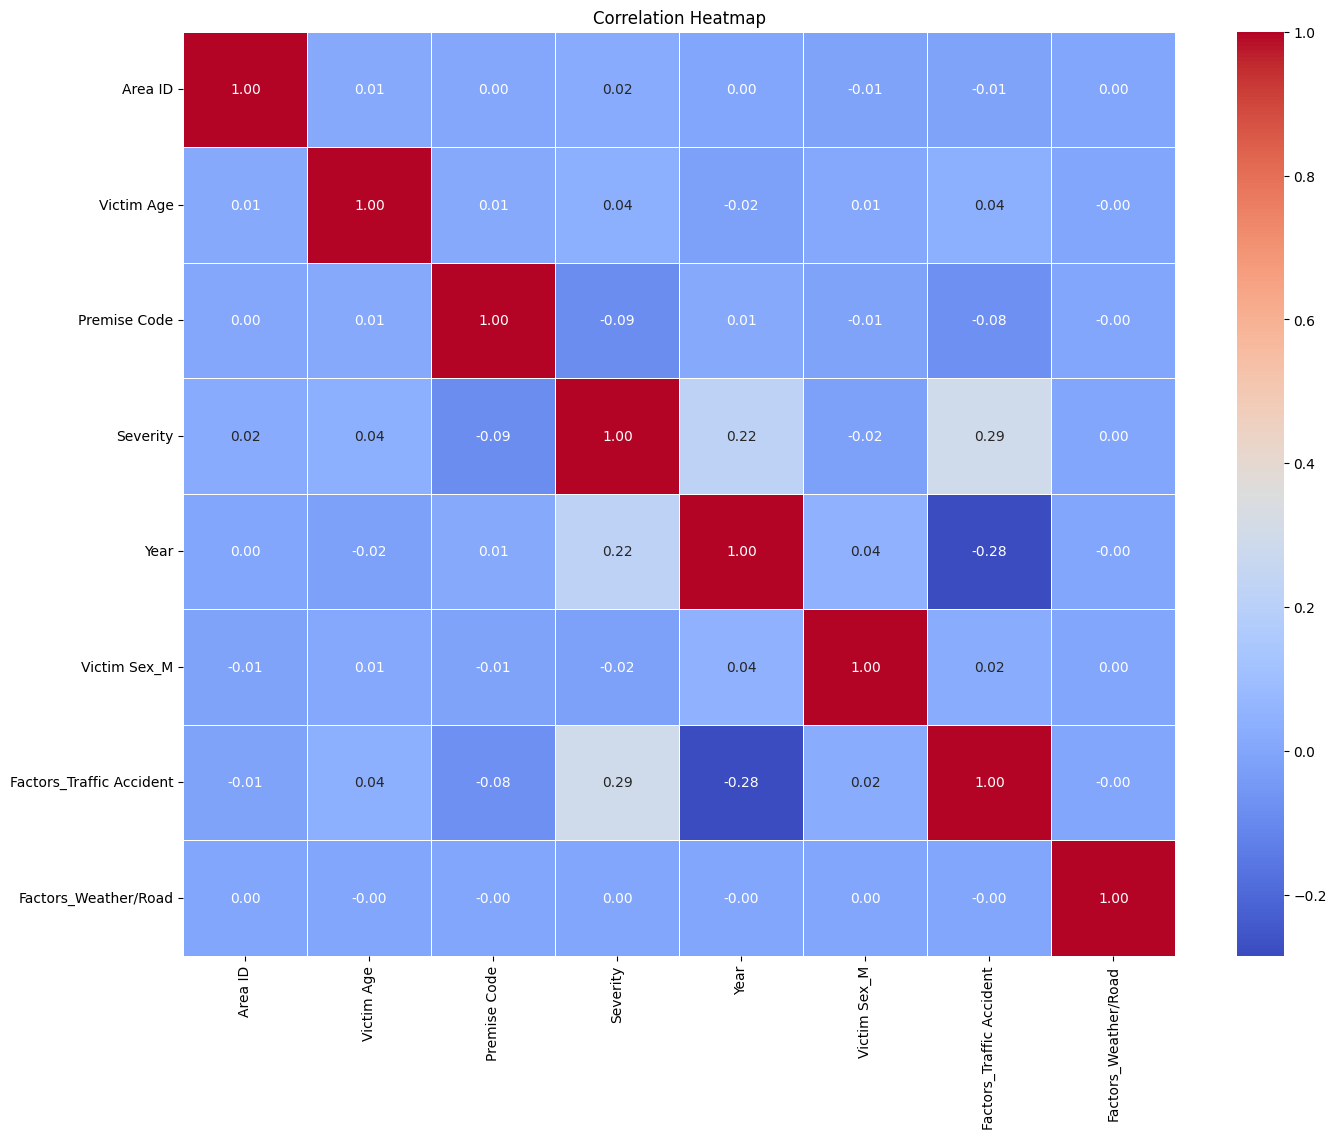

In [23]:
# Select columns for encoding
columns_for_encoding = ['Area ID', 'Victim Age', 'Victim Sex', 'Premise Code', 'Severity', 'Factors', 'Year']

# One-hot encode selected columns
df_encoded = pd.get_dummies(df[columns_for_encoding],
                             columns=['Victim Sex', 'Factors'],
                             drop_first=True)  # Use drop_first to avoid multicollinearity

# Compute the correlation matrix
correlation_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Select features and target variable
X = df.drop(columns=['Severity'])
y = df['Severity']

# One-hot encode categorical variables
categorical_columns = ['Victim Sex', 'Factors', 'Day of Week', 'Month']
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Min-Max scaling for numerical variables
numerical_columns = ['Victim Age', 'Latitude', 'Longitude', 'Hour']
scaler = MinMaxScaler()
X_encoded[numerical_columns] = scaler.fit_transform(X_encoded[numerical_columns])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

## **Random Forest Classifier:**

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report_result)


Accuracy: 0.7946

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     72835
           1       0.74      0.71      0.73     44794

    accuracy                           0.79    117629
   macro avg       0.78      0.78      0.78    117629
weighted avg       0.79      0.79      0.79    117629



In [55]:
# Display confusion matrix
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix for Random Forest:
[[61446 11389]
 [12776 32018]]


## **K-Nearest Neighbors (KNN) Classifier:**

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Build a K-Nearest Neighbors model
knn_model = KNeighborsClassifier()

# Train the model
knn_model.fit(X_train, y_train)

# Predictions on the test set
knn_y_pred = knn_model.predict(X_test)

# Evaluate the model
knn_accuracy = accuracy_score(y_test, knn_y_pred)
print(f"KNN Accuracy: {knn_accuracy:.2f}")

# Additional evaluation metrics
print("KNN Classification Report:")
print(classification_report(y_test, knn_y_pred))


KNN Accuracy: 0.76
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     72835
           1       0.69      0.66      0.67     44794

    accuracy                           0.76    117629
   macro avg       0.74      0.74      0.74    117629
weighted avg       0.75      0.76      0.75    117629



In [54]:
# Display confusion matrix
print("Confusion Matrix for KNN:")
print(confusion_matrix(y_test, knn_y_pred))

Confusion Matrix for KNN:
[[59273 13562]
 [15237 29557]]


## **Logistic Regression:**

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Build a Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Predictions on the test set
logreg_y_pred = logreg_model.predict(X_test)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, logreg_y_pred)
print(f"Logistic Regression Accuracy: {logreg_accuracy:.2f}")

# Additional evaluation metrics
print("Logistic Regression Classification Report:")
print(classification_report(y_test, logreg_y_pred))


Logistic Regression Accuracy: 0.68
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     72835
           1       0.59      0.55      0.57     44794

    accuracy                           0.68    117629
   macro avg       0.66      0.66      0.66    117629
weighted avg       0.68      0.68      0.68    117629



In [56]:
# Display confusion matrix
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test, logreg_y_pred))

Confusion Matrix for Logistic Regression:
[[55982 16853]
 [20321 24473]]


## **Gradient Boosting Classifier:**

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Build a Gradient Boosting Classifier model
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Predictions on the test set
gb_y_pred = gb_model.predict(X_test)

# Evaluate the model
gb_accuracy = accuracy_score(y_test, gb_y_pred)
print(f"Gradient Boosting Accuracy: {gb_accuracy:.2f}")

# Additional evaluation metrics
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_y_pred))


Gradient Boosting Accuracy: 0.79
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     72835
           1       0.72      0.72      0.72     44794

    accuracy                           0.79    117629
   macro avg       0.78      0.78      0.78    117629
weighted avg       0.79      0.79      0.79    117629



In [57]:
# Display confusion matrix
print("Confusion Matrix for Gradient Boosting:")
print(confusion_matrix(y_test, gb_y_pred))

Confusion Matrix for Gradient Boosting:
[[60482 12353]
 [12458 32336]]


## **XGBoost Classifier:**

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Build an XGBoost Classifier model
xgb_model = XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions on the test set
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")

# Additional evaluation metrics
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_y_pred))


XGBoost Accuracy: 0.80
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     72835
           1       0.74      0.73      0.74     44794

    accuracy                           0.80    117629
   macro avg       0.79      0.79      0.79    117629
weighted avg       0.80      0.80      0.80    117629



In [58]:
# Display confusion matrix
print("Confusion Matrix for Gradient Boosting:")
print(confusion_matrix(y_test, xgb_y_pred))

Confusion Matrix for Gradient Boosting:
[[61186 11649]
 [11995 32799]]


## **ADABoost Classifier:**

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Build an AdaBoost Classifier model
ada_model = AdaBoostClassifier(random_state=42)

# Train the model
ada_model.fit(X_train, y_train)

# Predictions on the test set
ada_y_pred = ada_model.predict(X_test)

# Evaluate the model
ada_accuracy = accuracy_score(y_test, ada_y_pred)
print(f"AdaBoost Accuracy: {ada_accuracy:.2f}")

# Additional evaluation metrics
print("AdaBoost Classification Report:")
print(classification_report(y_test, ada_y_pred))


AdaBoost Accuracy: 0.78
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     72835
           1       0.71      0.73      0.72     44794

    accuracy                           0.78    117629
   macro avg       0.77      0.77      0.77    117629
weighted avg       0.78      0.78      0.78    117629



## **Ensemble Model (Voting Classifier):**

In [45]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create individual models
rf_classifier = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier()
logreg_model = LogisticRegression(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
ada_model = AdaBoostClassifier(random_state=42)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('rf',rf_classifier),
    ('knn', knn_model),
    ('logreg', logreg_model),
    ('gb', gb_model),
    ('xgb', xgb_model),
    ('ada', ada_model)
], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Predictions on the test set
ensemble_y_pred = ensemble_model.predict(X_test)

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_y_pred)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.2f}")

# Additional evaluation metrics
print("Ensemble Model Classification Report:")
print(classification_report(y_test, ensemble_y_pred))


Ensemble Model Accuracy: 0.79
Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     72835
           1       0.74      0.71      0.72     44794

    accuracy                           0.79    117629
   macro avg       0.78      0.78      0.78    117629
weighted avg       0.79      0.79      0.79    117629



In [59]:
# Display confusion matrix
print("Confusion Matrix for Voting Classifier:")
print(confusion_matrix(y_test, ensemble_y_pred))

Confusion Matrix for Voting Classifier:
[[61569 11266]
 [13016 31778]]


**Parameter Tuning**

In [47]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    # Add other hyperparameters you want to tune
}

# Create a RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Create GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Predictions on the test set using the best model
y_pred_tuned = best_model.predict(X_test)

# Evaluate the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned Model Accuracy: {accuracy_tuned:.2f}")

# Additional evaluation metrics for the tuned model
print("Classification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))


Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Tuned Model Accuracy: 0.80
Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     72835
           1       0.73      0.74      0.73     44794

    accuracy                           0.80    117629
   macro avg       0.78      0.79      0.78    117629
weighted avg       0.80      0.80      0.80    117629



In [60]:

# Display confusion matrix
print("Confusion Matrix for Hypertuned Random Forest:")
print(confusion_matrix(y_test, y_pred_tuned))

Confusion Matrix for Hypertuned Random Forest:
[[60643 12192]
 [11754 33040]]
